In [7]:
!pip install scipy numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 8.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import glob
import os

# Initialize dictionaries to store data
prices_data = {}
trades_data = {}

# Define the days and bottles to process
days = [-1, 0, 1]
bottles = range(1, 7)

# Loop through all matching folders
for folder in glob.glob('round-3-island-data-bottle*'):
    # Extract bottle number from folder name
    # Handle both formats: "round-3-island-data-bottle1" and "round-3-island-data-bottle-1"
    bottle_num = ''.join(filter(str.isdigit, folder))
    if not bottle_num:  # If no numbers found, skip this folder
        continue
    bottle_num = int(bottle_num)
    
    # Process each day
    for day in days:
        # Read prices file
        prices_file = f'{folder}/prices_round_3_day_{day}.csv'
        if os.path.exists(prices_file):
            prices_df = pd.read_csv(prices_file, sep=';')
            key = f'prices_day_{day}_bottle_{bottle_num}'
            prices_data[key] = prices_df
            print(f"Loaded {key}: {prices_df.shape}")
        
        # Read trades file
        trades_file = f'{folder}/trades_round_3_day_{day}.csv'
        if os.path.exists(trades_file):
            trades_df = pd.read_csv(trades_file)
            key = f'trades_day_{day}_bottle_{bottle_num}'
            trades_data[key] = trades_df
            print(f"Loaded {key}: {trades_df.shape}")

Loaded prices_day_0_bottle_36: (140000, 17)
Loaded trades_day_0_bottle_36: (18123, 1)
Loaded prices_day_1_bottle_36: (140000, 17)
Loaded trades_day_1_bottle_36: (18000, 1)
Loaded prices_day_0_bottle_3: (140000, 17)
Loaded trades_day_0_bottle_3: (18123, 1)
Loaded prices_day_1_bottle_3: (140000, 17)
Loaded trades_day_1_bottle_3: (18000, 1)
Loaded prices_day_0_bottle_35: (140000, 17)
Loaded trades_day_0_bottle_35: (18123, 1)
Loaded prices_day_1_bottle_35: (140000, 17)
Loaded trades_day_1_bottle_35: (18000, 1)
Loaded prices_day_0_bottle_32: (140000, 17)
Loaded trades_day_0_bottle_32: (18123, 1)
Loaded prices_day_1_bottle_32: (140000, 17)
Loaded trades_day_1_bottle_32: (18000, 1)
Loaded prices_day_0_bottle_33: (140000, 17)
Loaded trades_day_0_bottle_33: (18123, 1)
Loaded prices_day_1_bottle_33: (140000, 17)
Loaded trades_day_1_bottle_33: (18000, 1)
Loaded prices_day_0_bottle_34: (140000, 17)
Loaded trades_day_0_bottle_34: (18123, 1)
Loaded prices_day_1_bottle_34: (140000, 17)
Loaded trades_

In [10]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call_price(S, K, T, sigma):
    """
    Calculate Black-Scholes call option price.
    
    Parameters:
    S (float): Current price of the underlying asset
    K (float): Strike price
    T (float): Time to expiry in years
    sigma (float): Volatility
    
    Returns:
    float: Call option price
    """
    # Calculate d1 and d2
    d1 = (np.log(S/K) + (sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    # Calculate call price
    call_price = S * norm.cdf(d1) - K * norm.cdf(d2)
    return call_price

def implied_volatility_call(C_market, S, K, T):
    """
    Calculate implied volatility using Brent's method.
    
    Parameters:
    C_market (float): Market price of the call option
    S (float): Current price of the underlying asset
    K (float): Strike price
    T (float): Time to expiry in years
    
    Returns:
    float: Implied volatility, or NaN if solution fails
    """
    # Define the function to find root of
    def f(sigma):
        return black_scholes_call_price(S, K, T, sigma) - C_market
    
    try:
        # Use Brent's method to find implied volatility
        # Set reasonable bounds for volatility (0.1% to 500%)
        iv = brentq(f, 0.001, 5.0)
        return iv
    except ValueError:
        # Return NaN if solution fails
        return np.nan

In [13]:
# Select a specific prices dataframe
prices_df = prices_data['prices_day_0_bottle_3']

# Get underlying and option prices
underlying = prices_df[prices_df['product'] == 'VOLCANIC_ROCK'][['timestamp', 'mid_price']]
options = prices_df[prices_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'][['timestamp', 'mid_price']]

# Merge the dataframes
merged = pd.merge(underlying, options, on='timestamp', suffixes=('_S', '_V'))

# Rename columns
merged = merged.rename(columns={
    'mid_price_S': 'S_t',
    'mid_price_V': 'V_t'
})

# Add TTE (constant for day 0)
merged['TTE'] = 7 / 252

# Calculate moneyness
merged['m'] = np.log(10000 / merged['S_t']) / np.sqrt(merged['TTE'])

# Calculate implied volatility
merged['v'] = merged.apply(
    lambda row: implied_volatility_call(row['V_t'], row['S_t'], 10000, row['TTE']),
    axis=1
)

# Select and reorder columns
result = merged[['timestamp', 'S_t', 'V_t', 'TTE', 'm', 'v']]

# Drop rows with missing or invalid values
result = result.dropna()

# Display the head
result.head()

,timestamp,S_t,V_t,TTE,m,v
0,0,10503.0,505.5,0.027778,-0.294455,0.150991
1,100,10510.0,515.5,0.027778,-0.298453,0.175652
2,200,10513.0,516.5,0.027778,-0.300165,0.162362
3,300,10517.5,521.5,0.027778,-0.302733,0.167412
4,400,10509.5,512.5,0.027778,-0.298167,0.157252


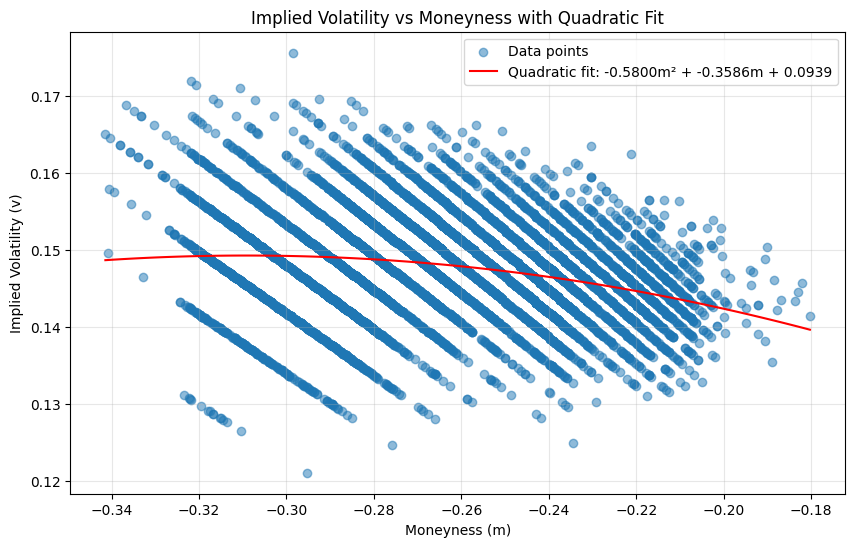

In [14]:
import matplotlib.pyplot as plt

# Fit a quadratic polynomial to the data
coefficients = np.polyfit(result['m'], result['v'], 2)
poly = np.poly1d(coefficients)

# Create a range of moneyness values for the fitted curve
m_range = np.linspace(result['m'].min(), result['m'].max(), 100)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(result['m'], result['v'], alpha=0.5, label='Data points')
plt.plot(m_range, poly(m_range), 'r-', label=f'Quadratic fit: {coefficients[0]:.4f}m² + {coefficients[1]:.4f}m + {coefficients[2]:.4f}')

# Add labels and title
plt.xlabel('Moneyness (m)')
plt.ylabel('Implied Volatility (v)')
plt.title('Implied Volatility vs Moneyness with Quadratic Fit')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

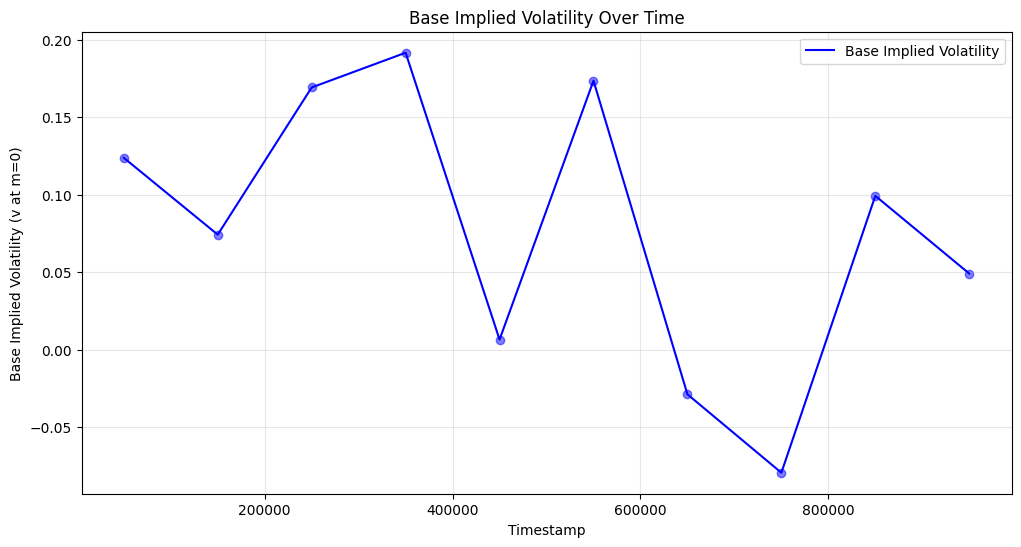

In [15]:
# Define window size
window_size = 1000

# Initialize lists to store results
timestamps = []
base_ivs = []

# Process data in windows
for i in range(0, len(result), window_size):
    window = result.iloc[i:i+window_size]
    
    if len(window) < 3:  # Need at least 3 points for quadratic fit
        continue
        
    # Fit quadratic to this window
    coefficients = np.polyfit(window['m'], window['v'], 2)
    poly = np.poly1d(coefficients)
    
    # Calculate base IV (v at m=0)
    base_iv = poly(0)
    
    # Store midpoint timestamp and base IV
    mid_timestamp = window['timestamp'].iloc[len(window)//2]
    timestamps.append(mid_timestamp)
    base_ivs.append(base_iv)

# Create DataFrame with results
base_iv_df = pd.DataFrame({
    'timestamp': timestamps,
    'base_iv': base_ivs
})

# Plot base IV over time
plt.figure(figsize=(12, 6))
plt.plot(base_iv_df['timestamp'], base_iv_df['base_iv'], 'b-', label='Base Implied Volatility')
plt.scatter(base_iv_df['timestamp'], base_iv_df['base_iv'], color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Base Implied Volatility (v at m=0)')
plt.title('Base Implied Volatility Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

In [16]:
# Fit quadratic to full data
coefficients = np.polyfit(result['m'], result['v'], 2)
poly_fit = np.poly1d(coefficients)

# Compute model values and mispricing
result['v_model'] = poly_fit(result['m'])
result['mispricing'] = result['v'] - result['v_model']

# Generate trading signals
result['signal'] = 'hold'
result.loc[result['mispricing'] < -0.01, 'signal'] = 'buy'
result.loc[result['mispricing'] > 0.01, 'signal'] = 'sell'

# Display relevant columns
result[['timestamp', 'v', 'v_model', 'mispricing', 'signal']].head()

,timestamp,v,v_model,mispricing,signal
0,0,0.150991,0.149174,0.001817,hold
1,100,0.175652,0.149233,0.026418,sell
2,200,0.162362,0.149253,0.013109,sell
3,300,0.167412,0.149276,0.018136,sell
4,400,0.157252,0.149230,0.008022,hold


In [17]:
# Initialize variables
total_pnl = 0
num_trades = 0
trades = []

# Iterate through the DataFrame
for i in range(len(result)):
    # Skip if we're too close to the end
    if i + 100 >= len(result):
        continue
        
    signal = result.iloc[i]['signal']
    if signal == 'hold':
        continue
        
    # Get entry and exit prices
    entry_price = result.iloc[i]['V_t']
    exit_price = result.iloc[i + 100]['V_t']
    
    # Calculate PnL
    if signal == 'buy':
        pnl = exit_price - entry_price
    else:  # signal == 'sell'
        pnl = entry_price - exit_price
    
    # Record trade
    trades.append({
        'timestamp': result.iloc[i]['timestamp'],
        'signal': signal,
        'entry_price': entry_price,
        'exit_price': exit_price,
        'pnl': pnl
    })
    
    total_pnl += pnl
    num_trades += 1

# Convert trades to DataFrame for better display
trades_df = pd.DataFrame(trades)

# Print results
print(f"Total PnL: {total_pnl:.2f}")
print(f"Number of trades: {num_trades}")
if num_trades > 0:
    print(f"Average PnL per trade: {total_pnl/num_trades:.2f}")

# Display first few trades
print("\nFirst few trades:")
trades_df.head()

Total PnL: 9905.00
Number of trades: 1041
Average PnL per trade: 9.51

First few trades:


,timestamp,signal,entry_price,exit_price,pnl
0,100,sell,515.5,429.5,86.0
1,200,sell,516.5,426.5,90.0
2,300,sell,521.5,426.5,95.0
3,500,sell,510.5,431.5,79.0
4,700,sell,507.5,434.5,73.0
